In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# SARIMAX modelling on time series

Notebook showing how to model and tune SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous) models to time-series data.

## Always on signals

Filtering and regressive methods tend to work best with signals where data containing some king of information is always present.

### Signal generation

Text(0.5, 1.0, 'sinusoidal test signal')

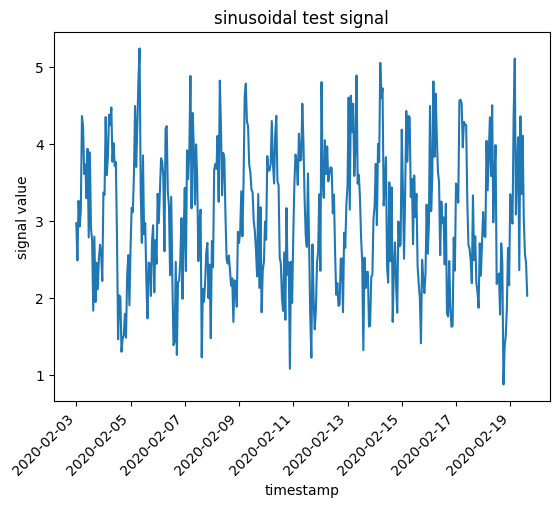

In [44]:
n_sample = 400
w_f = 2.0 * np.pi / 24.0
s_sin = 3 + np.sin([x * w_f for x in range(n_sample)]) + np.random.normal(loc=0.0, scale=0.5, size=n_sample)
t = [datetime(2020, 2, 3) + timedelta(hours=x) for x in range(n_sample)]
plt.plot(pd.DataFrame(
    {
        "data": s_sin, 
        "timestamp": t
    }).set_index("timestamp")
)
plt.xlabel("timestamp")
plt.xticks(rotation=45, ha="right")
plt.ylabel("signal value")
plt.title("sinusoidal test signal")

### Tuning and parameter analysis

This will be a recipe of
- testing for non-stationarity using Augmented Dickey-Fuller (explores d value in ARIMA order)
- analysis of moving average parameter via auto correlation (explores q value in ARIMA order)
- analysis of auto-regressive parameter via partial auto correlation (explores p value in ARIMA order)

In [32]:
def adfuller_in_dict(signal):
    return dict(zip(("ADF test statistic", "p-value", "no of lags used", "no of observations", "critical values", "maximized info criterion"), adfuller(signal)))

In [33]:
adfuller_in_dict(s_sin)

{'ADF test statistic': -8.203291828185844,
 'p-value': 7.134740270951081e-13,
 'no of lags used': 17,
 'no of observations': 382,
 'critical values': {'1%': -3.4475850438570115,
  '5%': -2.869135963767125,
  '10%': -2.5708164748773332},
 'maximized info criterion': 633.6983926523769}

The low p-value means that it is reasonable to reject the null hypothesis of the signal being non-stationary, and consider the signal to be stationary. 

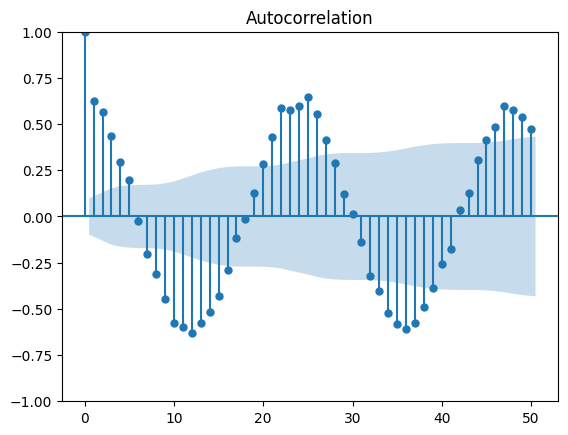

In [4]:
_ = plot_acf(s_sin, lags=50)

The autocorrelation suggests a 5 tap MA filter, and shows the periodicity of the signal every 24 samples, as expected.

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


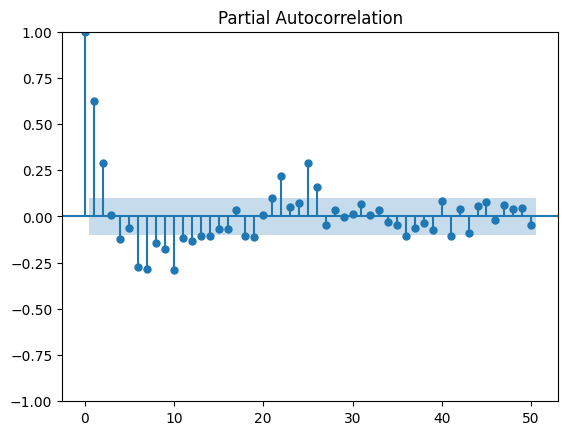

In [5]:
_ = plot_pacf(s_sin, lags=50)

The partial autocorrelation suggests a 2-3 tap AR filter, and shows the periodicity of the signal every 24 samples, as expected.

### Modelling

The tuning and parameter analysis can be used to build a model, and the resultant forecasting ability of the model can be plotted/analysed.

In [46]:
def plot_sarimax_results(order, seasonal_order, signal, timestamps, n_fit, alpha=0.05):
    s = signal
    t = timestamps
    model = SARIMAX(s[:n_fit], order=order, seasonal_order=seasonal_order, dates=t[:n_fit])
    results = model.fit()

    plt.plot(t, s, label="original signal")
    plt.plot(t[:n_fit], results.fittedvalues, color="red", label=f"SARIMAX{order}{seasonal_order} fitted values")

    predictions = results.predict(start=n_fit, end=n_sample-1)
    plt.plot(t[n_fit:], predictions, color="orange", label="prediction")

    forecast = results.get_forecast(n_sample - n_fit).conf_int(alpha=alpha)

    plt.fill_between(t[n_fit:], [x[0] for x in forecast], [x[1] for x in forecast], color=(0.01, 0.4, 0.6, 0.2), label=f"alpha={alpha} confidence interval")
    plt.legend(loc="upper left")
    plt.xlabel("timestamp")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("signal value")
    plt.title("SARIMAX modelling of signal")

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95505D-01    |proj g|=  2.76577D-01

At iterate    5    f=  8.68956D-01    |proj g|=  4.69895D-02

At iterate   10    f=  8.58384D-01    |proj g|=  1.10842D-02

At iterate   15    f=  8.56480D-01    |proj g|=  6.39047D-03

At iterate   20    f=  8.56061D-01    |proj g|=  1.40161D-02

At iterate   25    f=  8.53967D-01    |proj g|=  1.77565D-02

At iterate   30    f=  8.53861D-01    |proj g|=  1.57900D-03

At iterate   35    f=  8.53804D-01    |proj g|=  2.89221D-03

At iterate   40    f=  8.53044D-01    |proj g|=  1.97991D-02

At iterate   45    f=  8.48342D-01    |proj g|=  1.64378D-02


/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.47498D-01    |proj g|=  1.24971D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     65      1     0     0   1.250D-02   8.475D-01
  F =  0.84749756414357191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


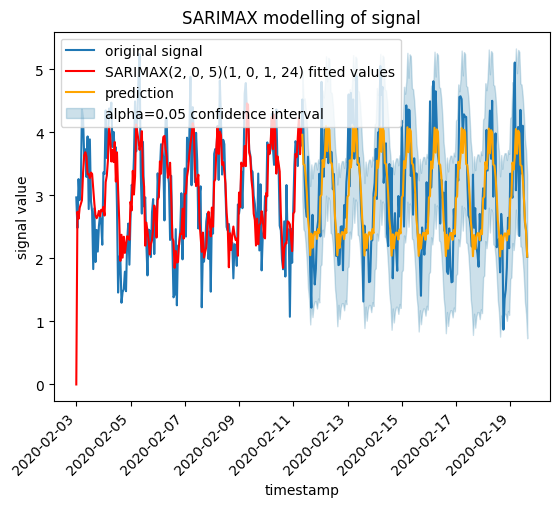

In [47]:
plot_sarimax_results((2, 0, 5), (1, 0, 1, 24), s_sin, t, n_fit=200)

## Periodic impulse signals

Impulsive signals can be trickier since much of the data contains no information

### Signal generation

Text(0.5, 1.0, 'periodic impulse test signal')

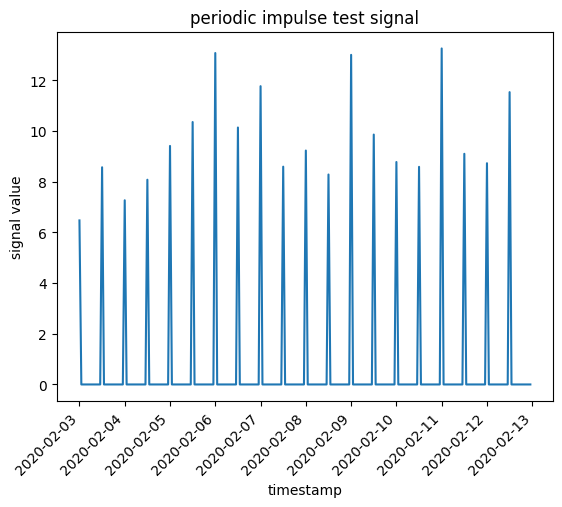

In [48]:
n_period = 20
period_samples = 12
n_sample = n_period * period_samples

s_periodic_impulse = np.zeros(n_sample)
s_periodic_impulse[::period_samples] = np.random.normal(loc=10, scale=2, size=n_period) 
t = [datetime(2020, 2, 3) + timedelta(hours=x) for x in range(n_sample)]

plt.plot(pd.DataFrame(
    {
        "data": s_periodic_impulse, 
        "timestamp": t
    }).set_index("timestamp")
)
plt.xlabel("timestamp")
plt.xticks(rotation=45, ha="right")
plt.ylabel("signal value")
plt.title("periodic impulse test signal")

### Tuning and parameter analysis

In [34]:
adfuller_in_dict(s_periodic_impulse)

{'ADF test statistic': -2.645699382958339,
 'p-value': 0.08391509015262044,
 'no of lags used': 11,
 'no of observations': 228,
 'critical values': {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 'maximized info criterion': 504.3137802339013}

The higher p-value means that the null hypothesis (that the signal is non-stationary) can only be rejected at the 10% level.

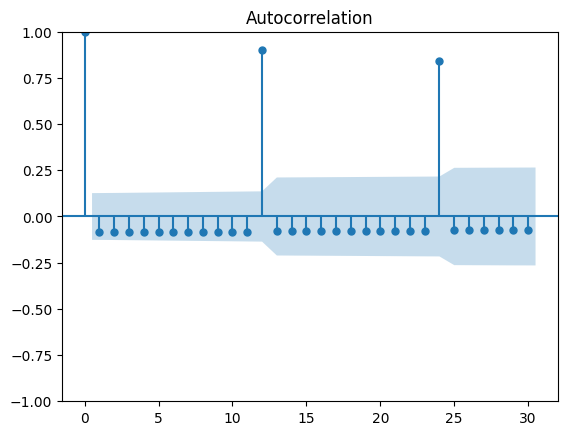

In [36]:
_ = plot_acf(s_periodic_impulse, lags=30)

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


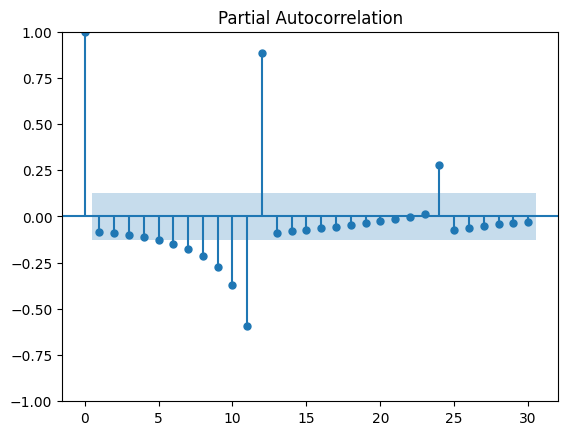

In [37]:
_ = plot_pacf(s_periodic_impulse, lags=30)

### Modelling

Even though the signal shows poorer stationary behaviour, SARIMAX still produces reasonable modelling results.

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74848D+00    |proj g|=  4.52046D+00

At iterate    5    f=  1.36827D+00    |proj g|=  2.03824D-01

At iterate   10    f=  1.14430D+00    |proj g|=  1.11643D+00

At iterate   15    f=  1.06093D+00    |proj g|=  1.89346D-01

At iterate   20    f=  9.77527D-01    |proj g|=  8.92769D-02

At iterate   25    f=  9.74020D-01    |proj g|=  4.66476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     43      1     0     0   

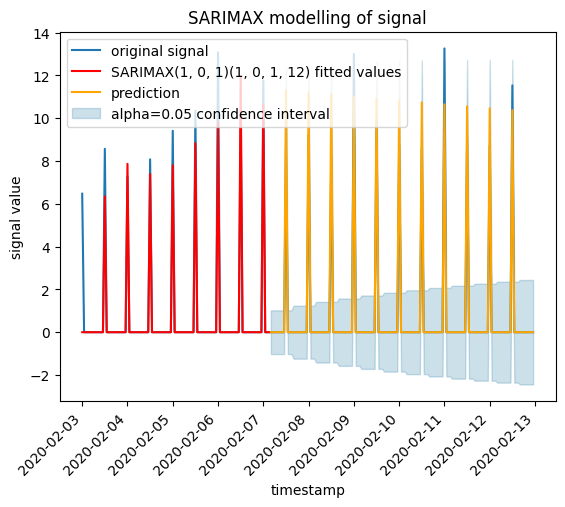

In [49]:
plot_sarimax_results((1, 0, 1), (1, 0, 1, 12), s_periodic_impulse, t, n_fit=100)